In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model,neural_network
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.decomposition import PCA

# Data Cleaning
After reading dataset from CSV file,  firstly drop irrelevant columns like "index" . Then handle missing values by dropping null values in subset['Q1','Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10’]. After that, convert categorical data into one-hot encode with dummy variable, during which the remained null values will be encoded as 0. The purpose of this step is to eliminate the misunderstanding of model for a categorical variable. For example, if we simply use numbers to replace counties in Q3, the model may assume an incremental of decremental relationship between countries of adjacent numbers. Then eliminate features that have too little variance using VarinaceThreshold method. The threshold used in the code is 0.05, which means 95% of the data is 1 or 0 for an encoded feature. After elimination, 327 columns are remained as features for the time being.

In [2]:
file = pd.read_csv("Kaggle_Salary.csv")
drop_columns=["Unnamed: 0","Time from Start to Finish (seconds)","Q32_OTHER","index"]
for column in file.columns.tolist():
    if ("_TEXT") in column:
        drop_columns.append(column)

file.drop(index=0,columns=drop_columns,inplace=True)
file.dropna(subset=['Q1','Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10'], inplace=True)
file_X = pd.get_dummies(file.drop(columns=["Q9"]))
var_thres = VarianceThreshold(threshold=(0.05)) #eliminate columns that have too little variance
var_thres.fit(file_X)
value_mask = var_thres.get_support()
file_X = file_X.loc[:,value_mask]
y = file["Q9"].astype(int)

C:\Users\Acer\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploratory data analysis
## a) 
explore the distribution of explainary variable

Text(0.5, 1.0, 'Total Salary Distribtuion in Dataset')

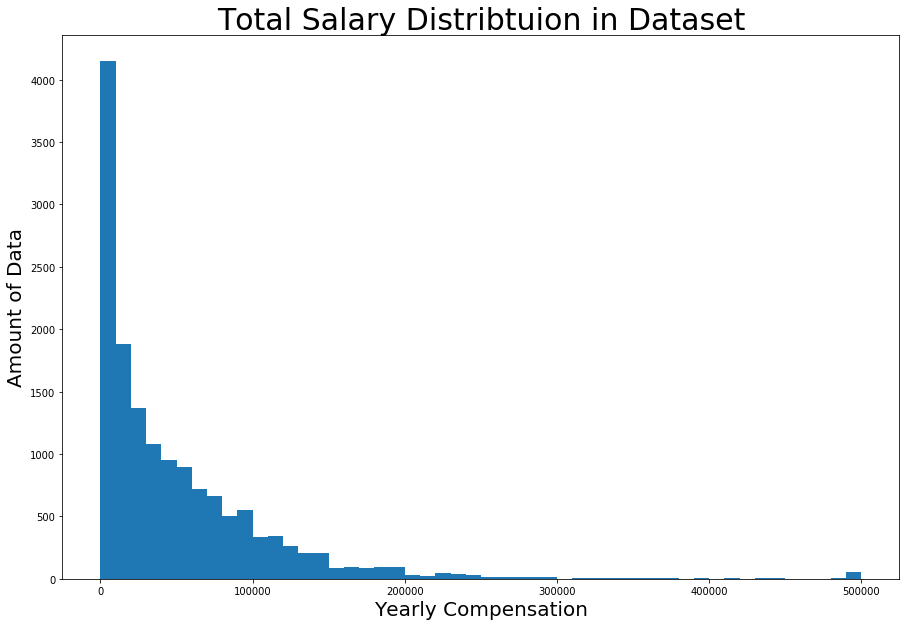

In [32]:
fig = plt.figure(figsize=(15,10))
plt.hist(y,bins=50)
plt.xlabel('Yearly Compensation', fontsize=20)
plt.ylabel('Amount of Data', fontsize=20)
plt.title('Total Salary Distribtuion in Dataset', fontsize=30)


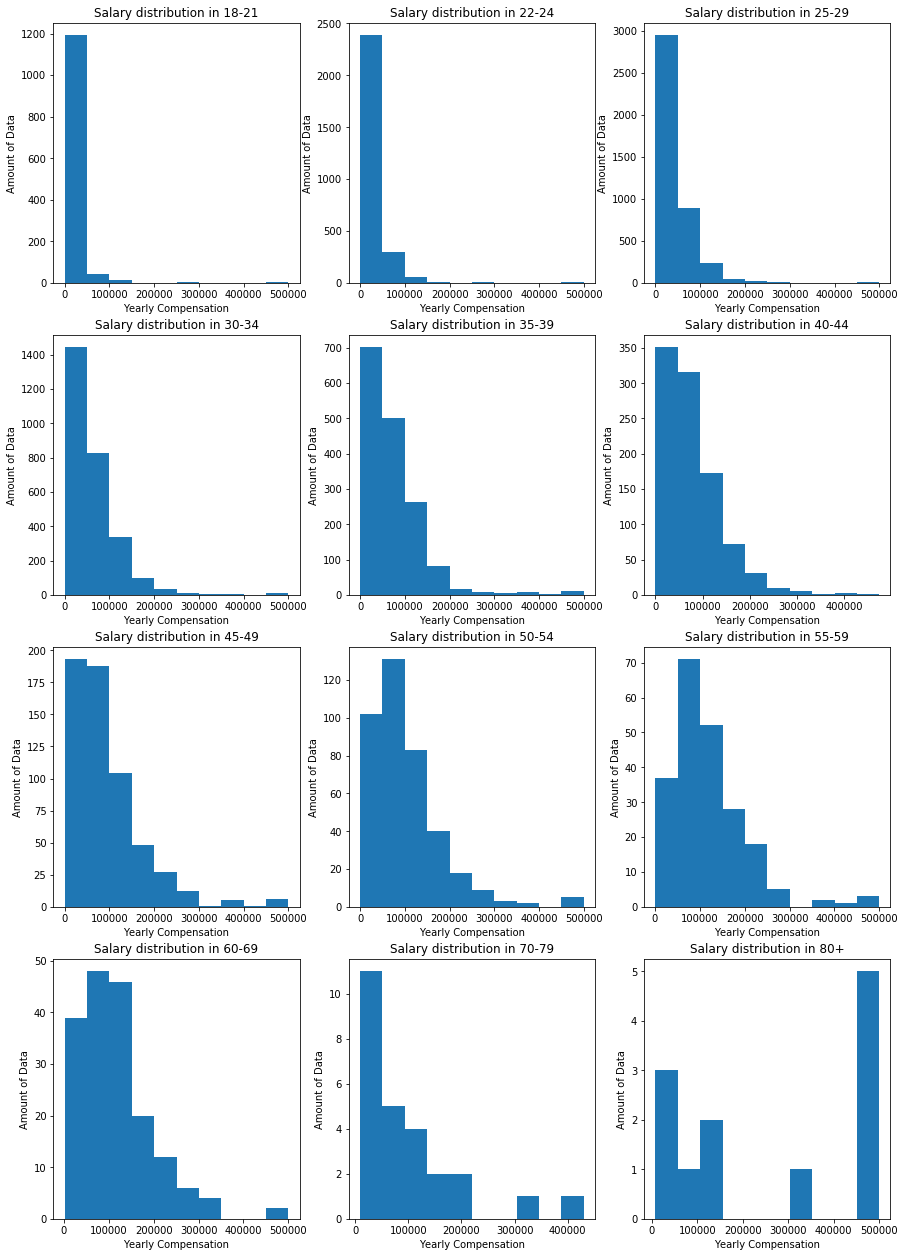

In [70]:
plt.figure(figsize=(15,22))
i = 1
for age in sorted(list(file.Q2.unique())):
    salary = y[file["Q2"]==age]
    ax = plt.subplot(4,3,i) # make subplot
    plt.hist(salary)
    plt.xlabel('Yearly Compensation', fontsize=10)
    plt.ylabel('Amount of Data', fontsize=10)
    plt.title('Salary distribution in ' + age)
    i+=1

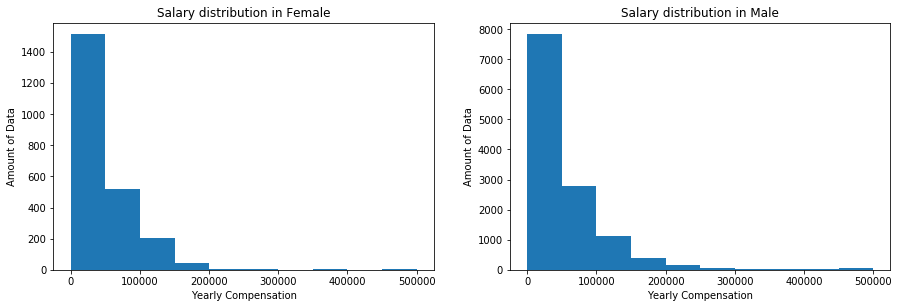

In [41]:
plt.figure(figsize=(15,10))
i = 1
for sex in sorted(list(file.Q1.unique()))[:2]:
    salary = y[file["Q1"]==sex]
    ax = plt.subplot(1,2,i)
    plt.hist(salary)
    plt.xlabel('Yearly Compensation', fontsize=10)
    plt.ylabel('Amount of Data', fontsize=10)
    plt.title('Salary distribution in ' + sex)
    i+=1

make a stripplot to vaulize relationship between job title and yearly compensation

Text(0, 0.5, 'Amount of Data')

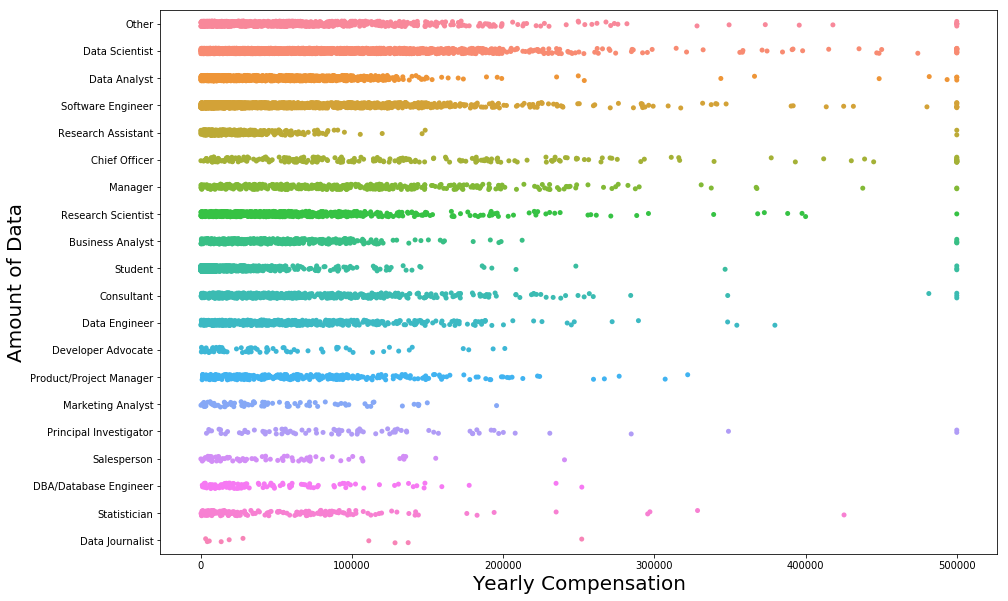

In [54]:
plt.figure(figsize=(15,10))
ax = sns.stripplot(x='Q9',y='Q6',data=pd.concat([y,file.Q6],axis=1),jitter=True)
plt.xlabel('Yearly Compensation', fontsize=20)
plt.ylabel('Job Title', fontsize=20)

## b)
Generate a correlation plot to visualize the order of feature importance. It can be seen that most features have little relationship with each other and features from Q3: currently residental country and from Q10:Incorporation of machine learning tend to higher influence on the respond variable.

<Figure size 432x288 with 0 Axes>

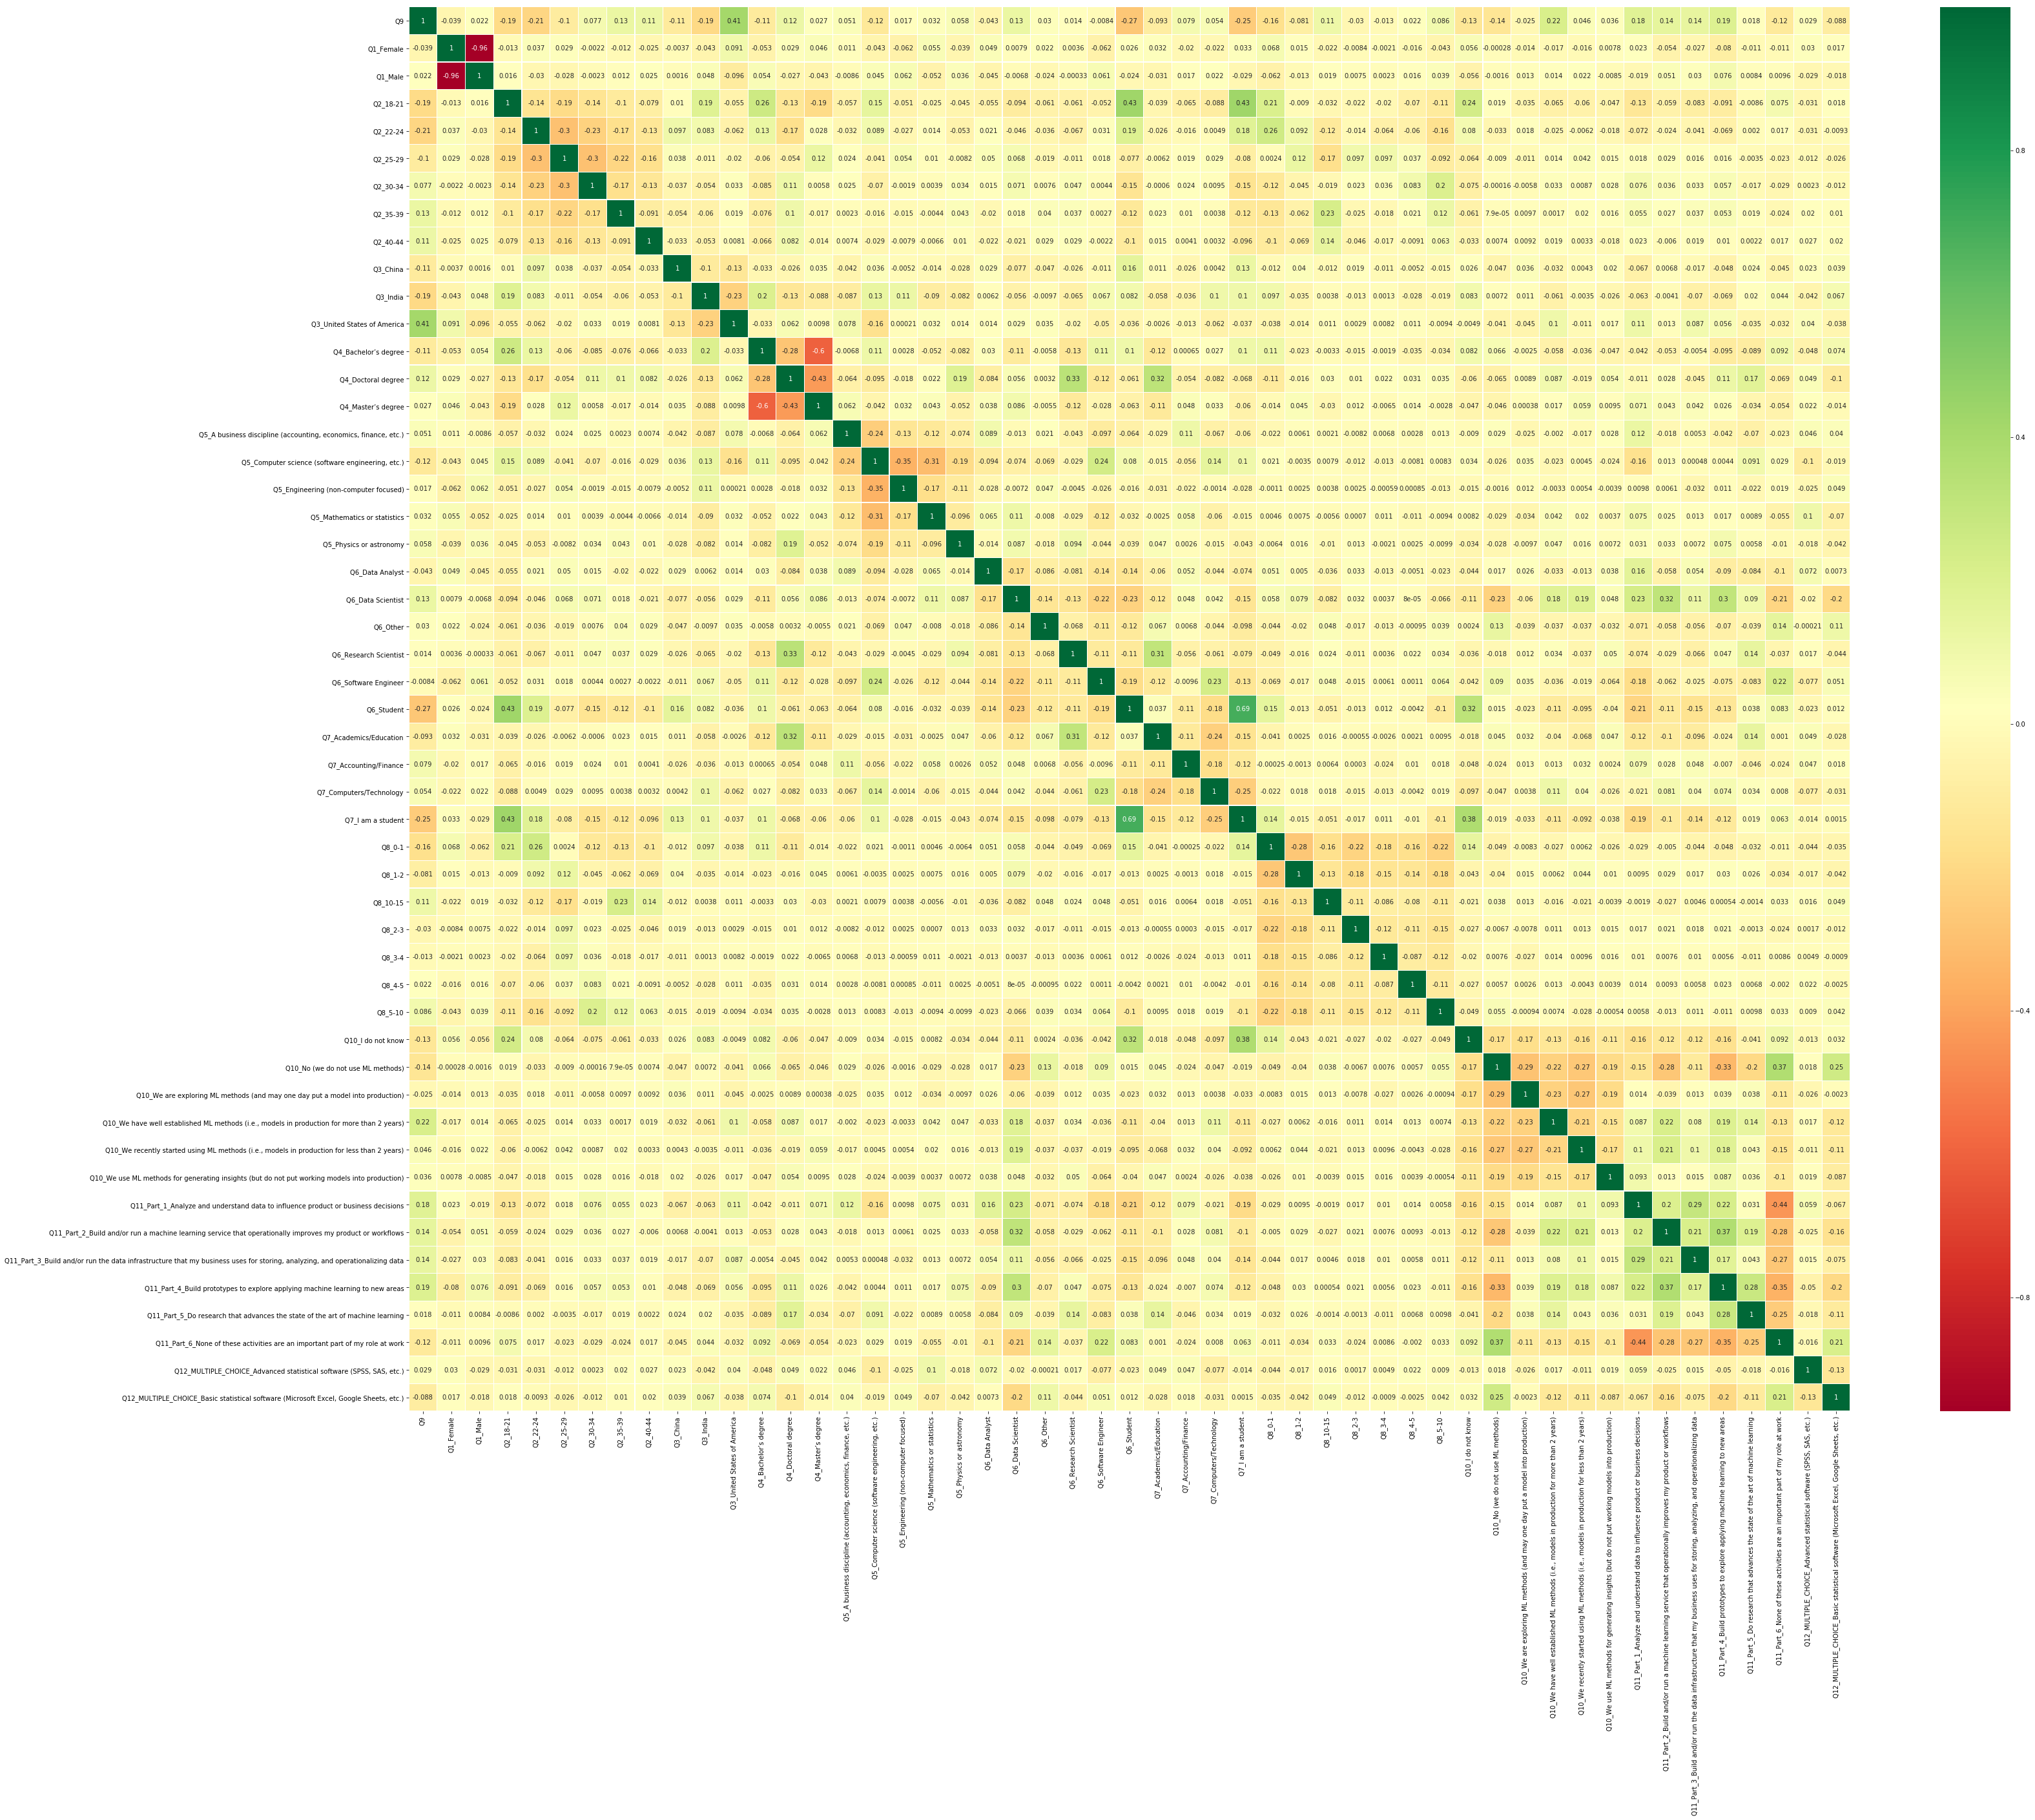

In [11]:
plt.figure()
figure(figsize=(50,40))
sns.heatmap(pd.concat([y,file_X.iloc[:,0:50]],axis=1).corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
plt.tick_params(length=4)
plt.show()

# Feature selection
Use RFE method to select features by recursively considering smaller and smaller sets of features. Ridge regularization is adapted as the estimator to assign weights to features. 

In [55]:
ridge_model = linear_model.Ridge(alpha = 0.1)
rfe = RFE(ridge_model,150,step=10)
fit = rfe.fit(file_X, y)
# sorted(list(zip(fit.ranking_,file_X_Train)))[0:150]
mask = fit.support_
selected_X = file_X.loc[:,mask]

# Model implementation
The selected regression methods are simple linear regression, lasso regression, gradient boosting regression and random forest regression. As shown in the result, every method presents a stable accuracy (r2 score) across the folds after feature selection. The gradient boosting regression model performed best.

In [56]:
def run_kfold(model,X,Y,X_Test,Y_Test):
    kf = KFold(n_splits=10) #n_splits previously n_folds
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        accuracy = model.score(X_test, Y_test)
        outcomes.append(accuracy)
        print("Fold %d accuracy: %.5f" % (fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    Test_Score = model.score(X_Test,y_Test)
    
    print("Mean accuracy: %.5f" % mean_outcome) 
    print("Standard Deviation: %.5f" % std_outcome)
    print ("------------------\n Test Score: %.5f" % Test_Score)

In [59]:
selected_X_Train,selected_X_Test,y_Train,y_Test = train_test_split(selected_X,y,test_size=0.3)
model_lr = linear_model.LinearRegression()
run_kfold (model_lr,selected_X_Train,y_Train,selected_X_Test,y_Test)

Fold 1 accuracy: 0.34604
Fold 2 accuracy: 0.47260
Fold 3 accuracy: 0.50746
Fold 4 accuracy: 0.42506
Fold 5 accuracy: 0.34733
Fold 6 accuracy: 0.48033
Fold 7 accuracy: 0.44363
Fold 8 accuracy: 0.58876
Fold 9 accuracy: 0.41760
Fold 10 accuracy: 0.40100
Mean accuracy: 0.44298
Standard Deviation: 0.06997
------------------
 Test Score: 0.40327


In [60]:
model_lasso = linear_model.Lasso(alpha = 1, max_iter=10000)
run_kfold (model_lasso,selected_X_Train,y_Train,selected_X_Test,y_Test)

Fold 1 accuracy: 0.34610
Fold 2 accuracy: 0.47263
Fold 3 accuracy: 0.50761
Fold 4 accuracy: 0.42511
Fold 5 accuracy: 0.34719
Fold 6 accuracy: 0.48039
Fold 7 accuracy: 0.44359
Fold 8 accuracy: 0.58876
Fold 9 accuracy: 0.41768
Fold 10 accuracy: 0.40104
Mean accuracy: 0.44301
Standard Deviation: 0.06999
------------------
 Test Score: 0.40327


In [61]:
model_gb = GradientBoostingRegressor(learning_rate = 0.15, n_estimators=150)
run_kfold (model_gb,selected_X_Train,y_Train,selected_X_Test,y_Test)

Fold 1 accuracy: 0.35599
Fold 2 accuracy: 0.51736
Fold 3 accuracy: 0.51445
Fold 4 accuracy: 0.43778
Fold 5 accuracy: 0.35874
Fold 6 accuracy: 0.49553
Fold 7 accuracy: 0.45188
Fold 8 accuracy: 0.59526
Fold 9 accuracy: 0.44523
Fold 10 accuracy: 0.41186
Mean accuracy: 0.45841
Standard Deviation: 0.07068
------------------
 Test Score: 0.41443


In [62]:
model_rfr = RandomForestRegressor(n_estimators=150)
run_kfold (model_rfr,selected_X_Train,y_Train,selected_X_Test,y_Test)

Fold 1 accuracy: 0.30367
Fold 2 accuracy: 0.46561
Fold 3 accuracy: 0.39480
Fold 4 accuracy: 0.39086
Fold 5 accuracy: 0.31750
Fold 6 accuracy: 0.47714
Fold 7 accuracy: 0.39121
Fold 8 accuracy: 0.53755
Fold 9 accuracy: 0.40614
Fold 10 accuracy: 0.33879
Mean accuracy: 0.40233
Standard Deviation: 0.07013
------------------
 Test Score: 0.37845


# Model tuning 

In [65]:
def gridsearch(para,model,X = selected_X_Train,Y = y_Train):
    # Compare parameters by score of model 
    acc_scorer = make_scorer(r2_score)

    # Run the grid search
    grid_obj = GridSearchCV(model, para, scoring=acc_scorer)
    grid_obj = grid_obj.fit(X,Y)

    reg_gridsearch = grid_obj.best_estimator_  #Select best parameter combination
    return reg_gridsearch

In [66]:
para_lasso = {'alpha':list(np.logspace(-3,2)), # Constant that multiplies the L1 term. Defaults to 1.0.
              'normalize':[True,False]}
gridsearch_lasso = gridsearch(para_lasso,model_lasso)

C:\Users\Acer\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [67]:
para_gb = {'learning_rate':list(np.logspace(-2,0,10,endpoint=0)),
           'n_estimators':[100,150,200,250]}
gridsearch_gb = gridsearch(para_gb,model_gb)

C:\Users\Acer\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [68]:
para_rfr = {'n_estimators':[100,150,200,250]}
gridsearch_rfr = gridsearch(para_rfr,model_rfr)

C:\Users\Acer\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


# Testing & Discussion
choose gridsearch_gb as optimal model.

In [69]:
run_kfold(gridsearch_gb,selected_X_Train,y_Train,selected_X_Test,y_Test)

Fold 1 accuracy: 0.35743
Fold 2 accuracy: 0.52339
Fold 3 accuracy: 0.51199
Fold 4 accuracy: 0.44007
Fold 5 accuracy: 0.35250
Fold 6 accuracy: 0.50006
Fold 7 accuracy: 0.45486
Fold 8 accuracy: 0.59909
Fold 9 accuracy: 0.44211
Fold 10 accuracy: 0.41036
Mean accuracy: 0.45919
Standard Deviation: 0.07277
------------------
 Test Score: 0.40738
